# SST-dev revalidation analysis

In [1]:
__author__ = 'Christopher Potts'

## Set-up

In [2]:
import os
import pandas as pd

import dynasent_utils as utils

In [3]:
src_filename = os.path.join(
    "dynasent-v1", "sst-dev-validated.jsonl")

## Load the dataset

In [4]:
sst = utils.load_dataset(src_filename)

In [5]:
sst[0]

{'hit_ids': ['s20533'],
 'sentence': '-LRB- A -RRB- n utterly charming and hilarious film that reminded me of the best of the Disney comedies from the 60s.',
 'tree': '(4 (2 (1 -LRB-) (2 (2 A) (3 -RRB-))) (4 (4 (2 n) (4 (3 (2 utterly) (4 (3 (4 charming) (2 and)) (4 hilarious))) (3 (2 film) (3 (2 that) (4 (4 (2 (2 reminded) (3 me)) (4 (2 of) (4 (4 (2 the) (4 best)) (2 (2 of) (3 (2 the) (3 (3 Disney) (2 comedies))))))) (2 (2 from) (2 (2 the) (2 60s)))))))) (2 .)))',
 'text_id': 'sst-dev-validate-0000437',
 'sst_label': '4',
 'label_distribution': {'positive': ['w207', 'w3', 'w840', 'w135', 'w26'],
  'negative': [],
  'neutral': [],
  'mixed': []},
 'gold_label': 'positive'}

## Validation label distributions

In [6]:
utils.get_label_distribution(sst, dist_labels=True)

positive    2129
negative    2052
mixed        712
neutral      612
Total       5505
dtype: int64

In [7]:
utils.get_label_distribution(sst, dist_labels=False)

positive        433
negative        421
mixed           108
neutral          75
No Majority      64
Total          1101
Name: gold_label, dtype: int64

## Relationship between validation labels and the original SST labels

In [8]:
df = pd.DataFrame(sst)

In [9]:
df.gold_label = df.gold_label.fillna("no majority")

In [10]:
cols = ['positive', 'negative', 'neutral', 'mixed', 'no majority']

In [11]:
xtab5 = pd.crosstab(df.gold_label, df.sst_label)

xtab5.loc[cols]

sst_label,0,1,2,3,4
gold_label,,,,,
positive,0,2,64,207,160
negative,132,227,57,5,0
neutral,0,8,44,22,1
mixed,6,29,39,32,2
no majority,1,23,25,13,2


In [12]:
sst_map = {
    '0': 'negative', '1': 'negative',
    '2': 'neutral',
    '3': 'positive', '4': 'positive'}

df['SST-3'] = df.sst_label.apply(lambda x: sst_map[x])

In [13]:
xtab = pd.crosstab(df.gold_label, df['SST-3'])

cols = ['positive', 'negative', 'neutral', 'mixed', 'no majority']

xtab[cols[: 3]].loc[cols]

SST-3,positive,negative,neutral
gold_label,,,
positive,367,2,64
negative,5,359,57
neutral,23,8,44
mixed,34,35,39
no majority,15,24,25


## Distribution of validation response distributions

In [14]:
utils.get_dist_of_majority_dists(sst)

5    528
4    278
3    231
dtype: int64

## Worker distribution

In [15]:
worker_dist = utils.get_global_worker_dist(sst)

worker_dist.shape

(103,)

In [16]:
worker_dist.head()

w135    280
w55     241
w3      220
w352    172
w26     171
dtype: int64

In [17]:
worker_dist.median()

31.0

In [18]:
worker_dist.mode()

0    10
dtype: int64

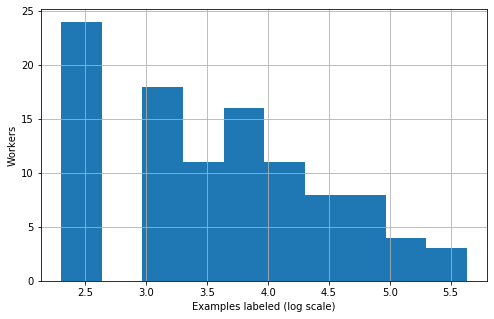

In [19]:
utils.plot_global_worker_dist(worker_dist)

## Examples for the paper

In [20]:
def sample_sst_examples_by_group(df, sst_labels, gold_labels, sampsize=0, random_state=1):
    sf = df[(df.gold_label.isin(gold_labels)) & (df['SST-3'].isin(sst_labels))].copy()
    sf['responses'] = sf['label_distribution'].apply(utils._format_dist)
    if sampsize == 0:
        samp = sf
    else:
        samp = sf.sample(sampsize, random_state=random_state)
    samp = samp[['sentence', 'SST-3', 'responses']].reset_index(drop=True)
    return samp.sort_values('SST-3')

In [21]:
sample_sst_examples_by_group(
    df,
    sst_labels=['negative'],
    gold_labels=['positive'],
    sampsize=0)

,sentence,SST-3,responses
0,Moretti's compelling anatomy of grief and the difficult process of adapting to loss.,negative,"neu, pos, pos, pos, pos"
1,Nothing is sacred in this gut-buster.,negative,"neg, neg, pos, pos, pos"


In [22]:
sample_sst_examples_by_group(
    df,
    sst_labels=['positive'],
    gold_labels=['negative'],
    sampsize=0)

,sentence,SST-3,responses
0,"... routine, harmless diversion and little else.",positive,"mix, mix, neg, neg, neg"
1,Hilariously inept and ridiculous.,positive,"mix, neg, neg, neg, neg"
2,Reign of Fire looks as if it was made without much thought--and is best watched that way.,positive,"mix, neg, neg, neg, neg"
3,"So much facile technique, such cute ideas, so little movie.",positive,"mix, mix, neg, neg, neg"
4,"While there's something intrinsically funny about Sir Anthony Hopkins saying ` Get in the car, bitch ,' this Jerry Bruckheimer production has little else to offer",positive,"mix, neg, neg, neg, neg"


In [23]:
sample_sst_examples_by_group(
    df,
    sst_labels=['neutral'],
    gold_labels=['positive', 'negative', 'mixed', 'neutral'],
    sampsize=10)

,sentence,SST-3,responses
0,"Returning aggressively to his formula of dimwitted comedy and even dimmer characters, Sandler, who also executive produces, has made a film that makes previous vehicles look smart and sassy.",neutral,"neg, neg, neg, neg, neg"
1,should be seen at the very least for its spasms of absurdist humor.,neutral,"pos, pos, pos, pos, pos"
2,A workshop mentality prevails.,neutral,"neu, neu, neu, neu, neu"
3,Van Wilder brings a whole new meaning to the phrase ` comedy gag . ',neutral,"mix, neu, pos, pos, pos"
4,` They' begins and ends with scenes so terrifying I'm still stunned.,neutral,"neu, neu, pos, pos, pos"
5,Barely gets off the ground.,neutral,"neg, neg, neg, neg, neg"
6,"As a tolerable diversion, the film suffices; a Triumph, however, it is not.",neutral,"mix, mix, mix, mix, neg"
7,"Christina Ricci comedy about sympathy, hypocrisy and love is a misfire.",neutral,"neg, neg, neg, neg, neg"
8,Jacquot's rendering of Puccini's tale of devotion and double-cross is more than just a filmed opera.,neutral,"neg, neu, pos, pos, pos"
9,Candid Camera on methamphetamines.,neutral,"neg, neg, neg, neu, pos"
